# LSTM Covid-19 Data Analysis

This notebook walks through implementing lstm neural networks as well as data loading on JHU's covid-19 time-series data, maintained here: https://github.com/CSSEGISandData/COVID-19. In the this walk-through, we use our predictor and data loader classes that are in the ML module in this repo.

In [1]:
# basic python libs
import os, wget, json

# deep learning frameowkr tools
import torch
from torch import nn, optim

# data analysis libs
import numpy as np, pandas as pd

# visualization libs
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

# ML pre-processing
from sklearn.preprocessing import MinMaxScaler

In [2]:
# our predictor and data loader
from ML.lstm_torch import LSTM_data_loader, LSTM_Predictor, train_lstm, predict_future

import warnings
warnings.filterwarnings('ignore')

Set all of our visualization preferences.

In [49]:
%matplotlib inline

In [50]:
sns.set(style='whitegrid', palette='muted', font_scale=1.6)
sns.set_palette(sns.color_palette("husl", 8))

rcParams['figure.figsize'] = 16, 12
register_matplotlib_converters()

In [51]:
# set our random seed
RANDOM_SEED = 26
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

For doing a country-level analysis, we'll want to download the most recent data from the JHU database. That said, up until 3/22, the researchers were reporting state level data. There was functionality built into the the data-loaidng class to subset down to the state-level for project covid -19 growth for each state.

In [23]:
if os.path.isfile('time_series_covid19_confirmed_global.csv'):
    os.remove('time_series_covid19_confirmed_global.csv')
    
wget.download('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

'time_series_covid19_confirmed_global.csv'

## World covid-19 Growth Analysis

Lets start out with not subsetting our data for modeling -- let's aggregate all of our information over the entire world, largely because as we have more data points and will have a better fitting model. Since we're using long short-term memory machine networks in order to model out confirmed-case growth, if we have a bunch of 0s at the beginning of out time-series data and it begins to ramp up quickly, our model is going to have a hard time fitting to the sudden jump. If we capture as much of that as possible (i.e. use as much of the data as possible) we should see better results.

In [57]:
tdf = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [58]:
tdf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,21,22,22,22,24,24,40,40,74,84
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,51,55,59,64,70,76,89,104,123,146
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,54,60,74,87,90,139,201,230,264,302
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,2,39,39,53,75,88,113,133,164,188
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,1,2,2,3,3,3


The first thing we're going to use is the `LSTM_data_loader` class. Since we're subsetting in a couple different way, for useability we wrapped some of the basic manipulations into a data loader class. Most importantly, we're passing in a dataframe of the format above (how JHU has been provindg their data). If we pass this in and no other arguments, we will simply prep our data to model at the world-level. After that, we can pass in a country name that exists in the `Country/Region` column that we would like to subset by. If we use one of the archived data sets that contains state-level information, we can pass in a state abbreviation as well. In order to do this, we also need to pass in a dictionary where the abbreviation maps to the name of the state (i.e {'WA' : 'Washington'}. This dictionary just helps capture all instances in the dataframe where the state is metnioned).

In [70]:
world_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country=None,
                                     region_list=None,
                                     state_mapper=None)

We still need to call the `subset_df` method off of our LSTM data loader as it still removes some columns off of our data that we're not going to want for the next step.

In [71]:
world_data_loader.subset_df()
world_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
0,0,0,0,0,0,0,0,0,0,0,...,21,22,22,22,24,24,40,40,74,84
1,0,0,0,0,0,0,0,0,0,0,...,51,55,59,64,70,76,89,104,123,146
2,0,0,0,0,0,0,0,0,0,0,...,54,60,74,87,90,139,201,230,264,302
3,0,0,0,0,0,0,0,0,0,0,...,2,39,39,53,75,88,113,133,164,188
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,2,3,3,3


For plotting out our data, making predictions, and generally working with our data, it's more convenient to have our data in a datetime format, so we transfor switch our axes and cast out time-step information to a date-time type. The `delta` argument determines if our new cases are either the cumulative amount of cases in a country, or the amount of new daily cases. This changes the coontext of what we're predicting and modeling as well. For this, we're sticking with cumulative cases as typically these networks have an easier time fitting to smoother curves. That said, daily differences more excplicitly capture factors such as momemntum and negative swings.

In [72]:
world_data_loader.transform_df_datetime(delta=False)
world_data_loader.df.head()

Data in cumulative


2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [67]:
len(world_data_loader.df)

64

Since we just packaged up a pandas dataframe inside of our loading class, we can still call easy pandas lotting features off of it. Inspecting the plot, we can see that there is significant momentum heading into February (the spike in cases in China) and a drop (a subsuquent dropping off ocf new reported cases there). At that point though, we can see the virus spread picking up again as it had reached other nations.

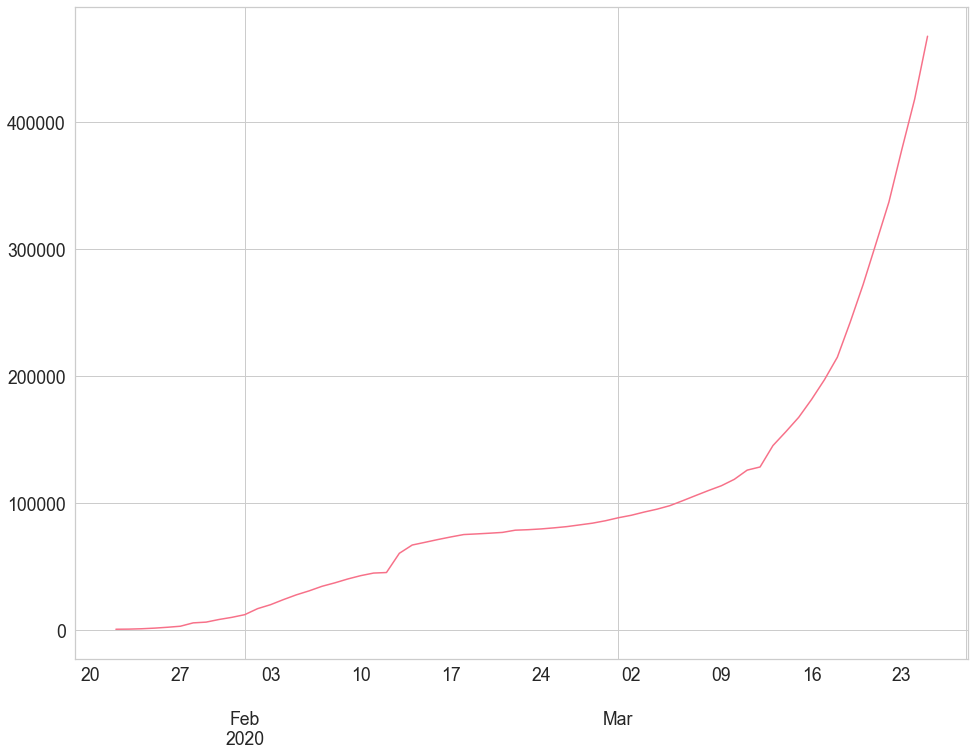

In [68]:
world_data_loader.df.plot(label="Confirmed Cases")

We can then call a method in the class to create our training and testing data sets. Pass in however much you wantfor the training data, but now we only have 56 days, forthis example I'm just going to pass in the last 5. The default value in the method is 0, which will not create a test data.

In [31]:
world_data_loader.gen_data_sets(test_data_size=7)

We then extract these data sets data sets and do some conversions into torch tensors.

In [32]:
X_train, y_train = world_data_loader.set_seq()
X_test, y_test = world_data_loader.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [33]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [34]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=500)

Epoch 0 train loss: 6.759359359741211 test loss: 8.815042495727539
Epoch 40 train loss: 2.077669620513916 test loss: 4.605196475982666
Epoch 80 train loss: 1.7559337615966797 test loss: 3.4739794731140137
Epoch 120 train loss: 0.1949295550584793 test loss: 0.3112955093383789
Epoch 160 train loss: 0.1555720418691635 test loss: 1.4070069789886475
Epoch 200 train loss: 0.16037774085998535 test loss: 1.4165215492248535
Epoch 240 train loss: 0.19787868857383728 test loss: 1.1000595092773438
Epoch 280 train loss: 0.15257638692855835 test loss: 1.1536024808883667
Epoch 320 train loss: 0.17425861954689026 test loss: 1.0975145101547241
Epoch 360 train loss: 0.170200914144516 test loss: 1.3809974193572998
Epoch 400 train loss: 0.15811973810195923 test loss: 1.197411060333252
Epoch 440 train loss: 0.1612183004617691 test loss: 1.4146722555160522
Epoch 480 train loss: 0.37478378415107727 test loss: 0.8458614349365234


In [35]:
seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = world_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[336952.97 378235.   418045.  ]
[307150.8710382  338567.32576919 369265.11678672]


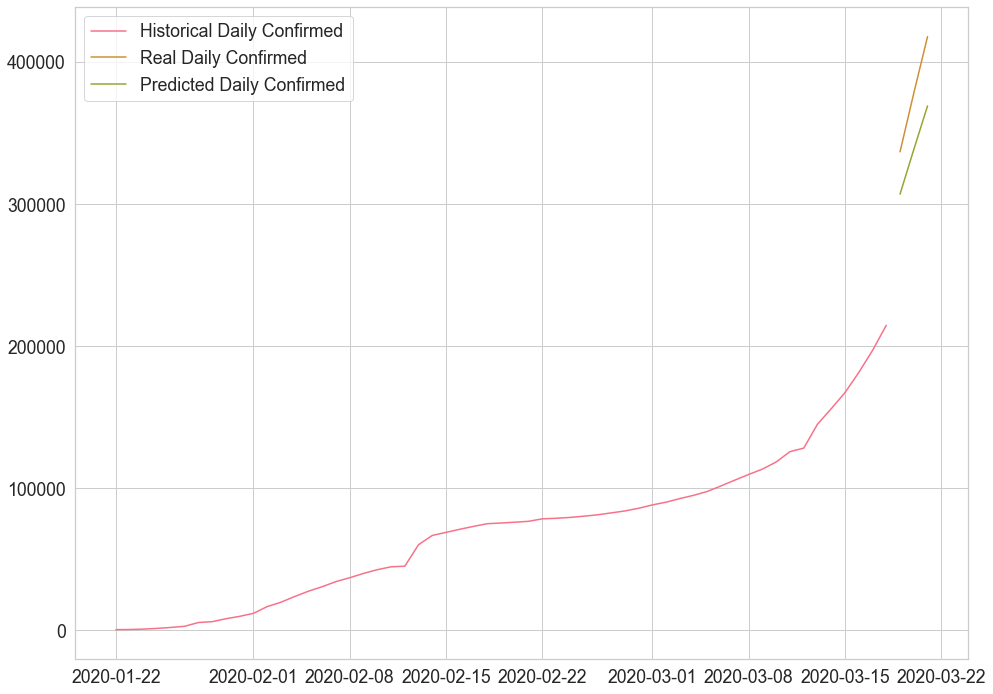

In [37]:
plt.plot(
  world_data_loader.df.index[:len(world_data_loader.train_data)],
  world_data_loader.scaler.inverse_transform(world_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  world_data_loader.df.index[len(world_data_loader.train_data):len(world_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  world_data_loader.df.index[len(world_data_loader.train_data):len(world_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

## World - Future

For our future, prediction, we the only real modifications that we make to our previous analysis is that we keep all of our data as training data for a better fit, and see what the model outputs!

In [74]:
world_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country=None,
                                     region_list=None,
                                     state_mapper=None)

world_data_loader.subset_df()

world_data_loader.transform_df_datetime(delta=True)

world_data_loader.gen_data_sets(test_data_size=0)

X_train, y_train = world_data_loader.set_seq()
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=500)


Data is converted to daily delta
Epoch 0 train loss: 3.2104358673095703
Epoch 40 train loss: 0.921194314956665
Epoch 80 train loss: 0.6172711253166199
Epoch 120 train loss: 0.5533851385116577
Epoch 160 train loss: 0.7079004645347595
Epoch 200 train loss: 0.642855703830719
Epoch 240 train loss: 0.6409525871276855
Epoch 280 train loss: 0.7098181247711182
Epoch 320 train loss: 0.6129046678543091
Epoch 360 train loss: 0.5594758987426758
Epoch 400 train loss: 0.6604916453361511
Epoch 440 train loss: 0.730443000793457
Epoch 480 train loss: 0.6501606702804565


In [78]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[ 60296.40656197  62129.96614087  65585.78100908  70052.16161907
  75211.12584472  80883.34857881  86952.06012118  93325.11916316
  99916.59749436 106638.8515234 ]


After all that... our model looks pretty inear, predicting an incrase of ~10k cases a day. 

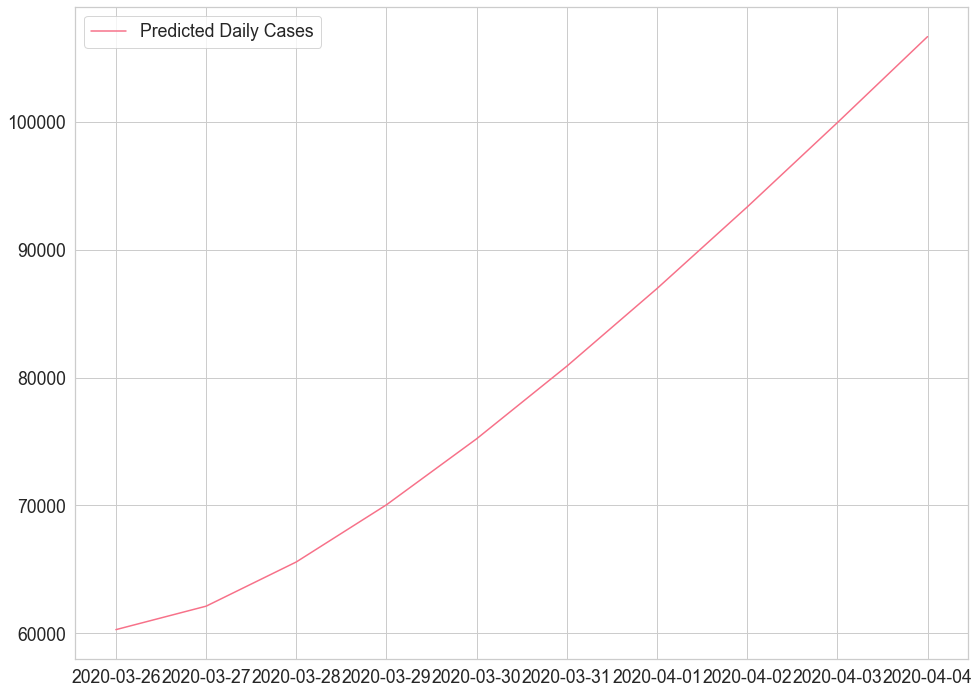

In [79]:
predicted_index = pd.date_range(
  start=world_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

And our data and predictions together.

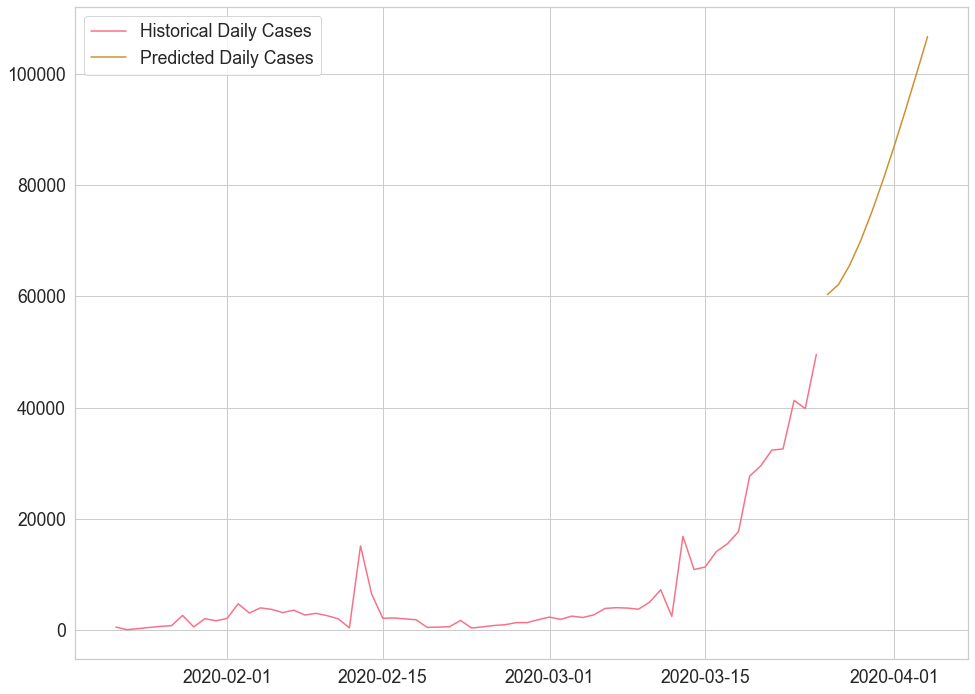

In [80]:
plt.plot(world_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

## Italian Analysis

Okay, lets try something a bit harder that ahs considerabley less data then then aggergating over the whole world. Lets do Italy.

In [96]:
italy_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country='Italy',
                                     region_list=None,
                                     state_mapper=None)

In [97]:
italy_data_loader.subset_df()
italy_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
0,0,0,0,0,0,0,0,0,0,2,...,27980,31506,35713,41035,47021,53578,59138,63927,69176,74386


In [98]:
italy_data_loader.transform_df_datetime(delta=True)
italy_data_loader.df.head()

Data is converted to daily delta


2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

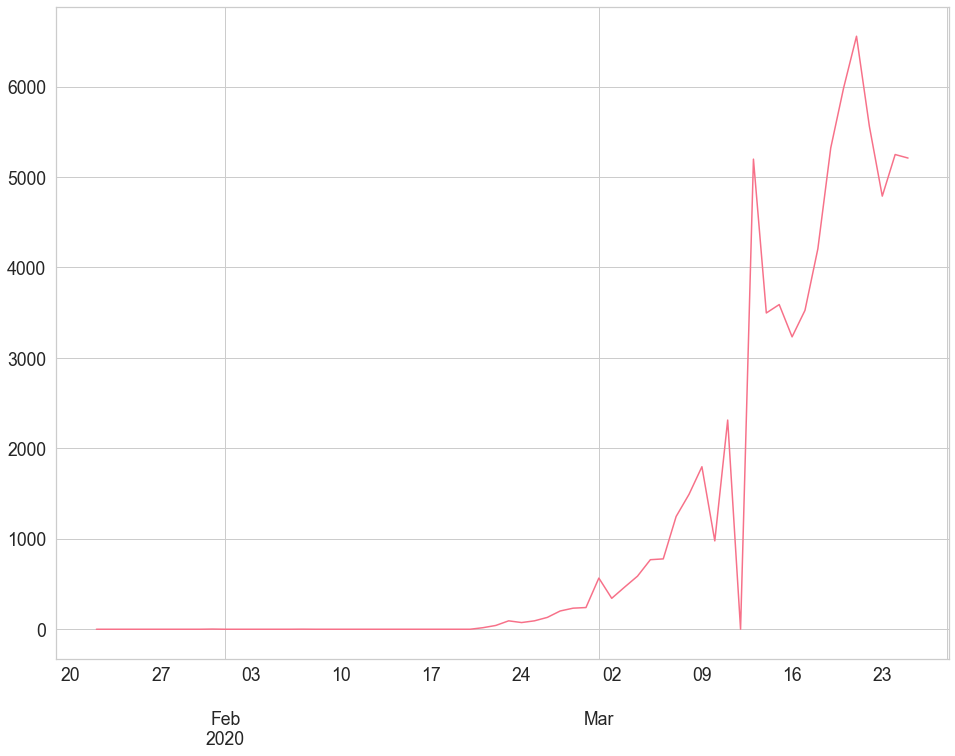

In [99]:
italy_data_loader.df.plot(label="Confirmed Cases")

In [100]:
italy_data_loader.gen_data_sets(test_data_size=7)

In [104]:
X_train, y_train = italy_data_loader.set_seq(sequence_lenth=3)
X_test, y_test = italy_data_loader.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [105]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [106]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=300)

Epoch 0 train loss: 3.563279628753662 test loss: 3.1148581504821777
Epoch 40 train loss: 1.7726671695709229 test loss: 1.2026842832565308
Epoch 80 train loss: 0.8070232272148132 test loss: 0.040909651666879654
Epoch 120 train loss: 0.7843297123908997 test loss: 0.02490665763616562
Epoch 160 train loss: 0.790210485458374 test loss: 0.03408311679959297
Epoch 200 train loss: 0.7581338882446289 test loss: 0.03448687493801117
Epoch 240 train loss: 0.7759703397750854 test loss: 0.05889744684100151
Epoch 280 train loss: 0.7854222059249878 test loss: 0.03985629975795746


In [107]:
seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = italy_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = italy_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[5560.     4789.     5249.0005]
[5999.37832737 6600.94187355 7190.41852903]


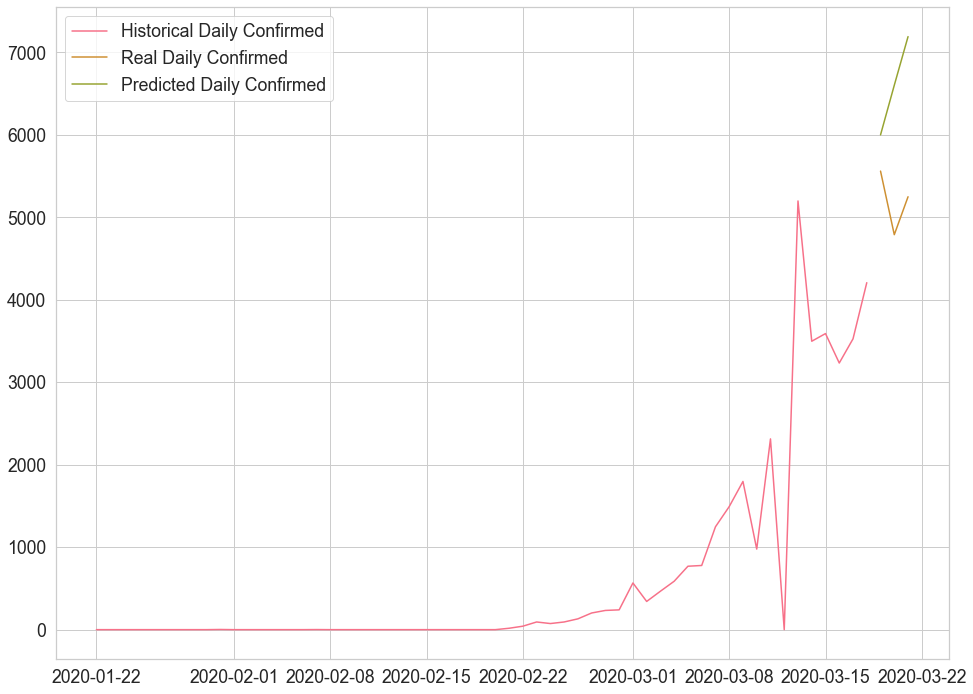

In [108]:
plt.plot(
  italy_data_loader.df.index[:len(italy_data_loader.train_data)],
  italy_data_loader.scaler.inverse_transform(italy_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  italy_data_loader.df.index[len(italy_data_loader.train_data):len(italy_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  italy_data_loader.df.index[len(italy_data_loader.train_data):len(italy_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

## Italy - Future

In [116]:
italy_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country="Italy",
                                     region_list=None,
                                     state_mapper=None)

italy_data_loader.subset_df()

italy_data_loader.transform_df_datetime(delta=True)

italy_data_loader.gen_data_sets(test_data_size=0)

X_train, y_train = italy_data_loader.set_seq()
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=500)


Data is converted to daily delta
Epoch 0 train loss: 6.604455471038818
Epoch 40 train loss: 1.1903146505355835
Epoch 80 train loss: 1.1992837190628052
Epoch 120 train loss: 1.614452600479126
Epoch 160 train loss: 1.0853201150894165
Epoch 200 train loss: 0.9237119555473328
Epoch 240 train loss: 0.8818630576133728
Epoch 280 train loss: 0.8902077078819275
Epoch 320 train loss: 0.7985752820968628
Epoch 360 train loss: 0.7746910452842712
Epoch 400 train loss: 0.7956010103225708
Epoch 440 train loss: 0.7053218483924866
Epoch 480 train loss: 0.7581348419189453


In [117]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[48154.83944678 50071.79837537 51800.59592128 53342.28725016
 54705.44337237 55901.09342158 56942.43581057 57843.84790814
 58620.07845426 59285.54608119]


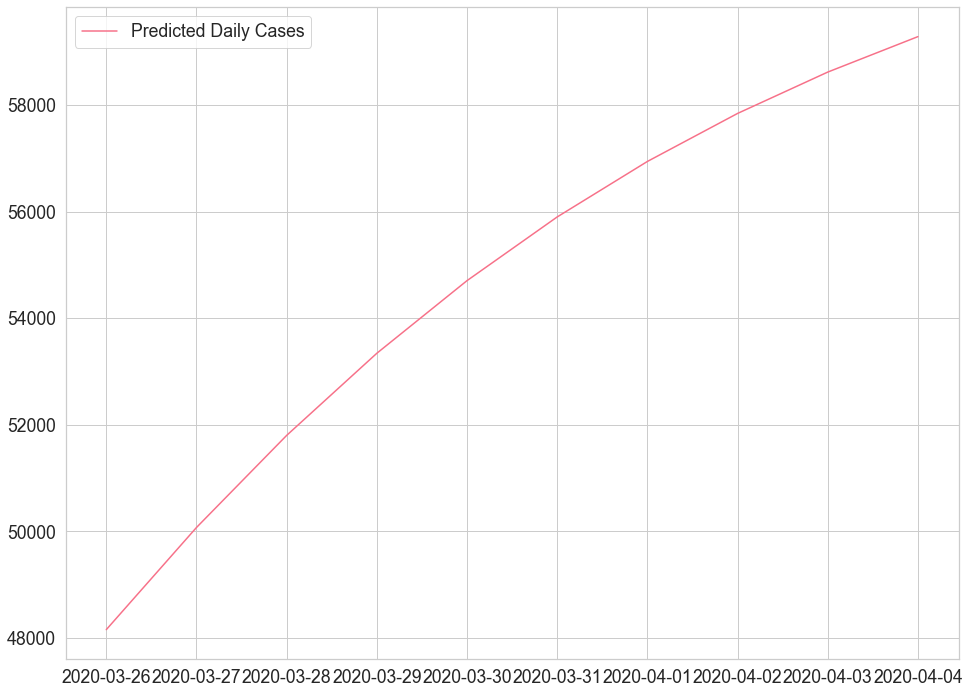

In [118]:
predicted_index = pd.date_range(
  start=world_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

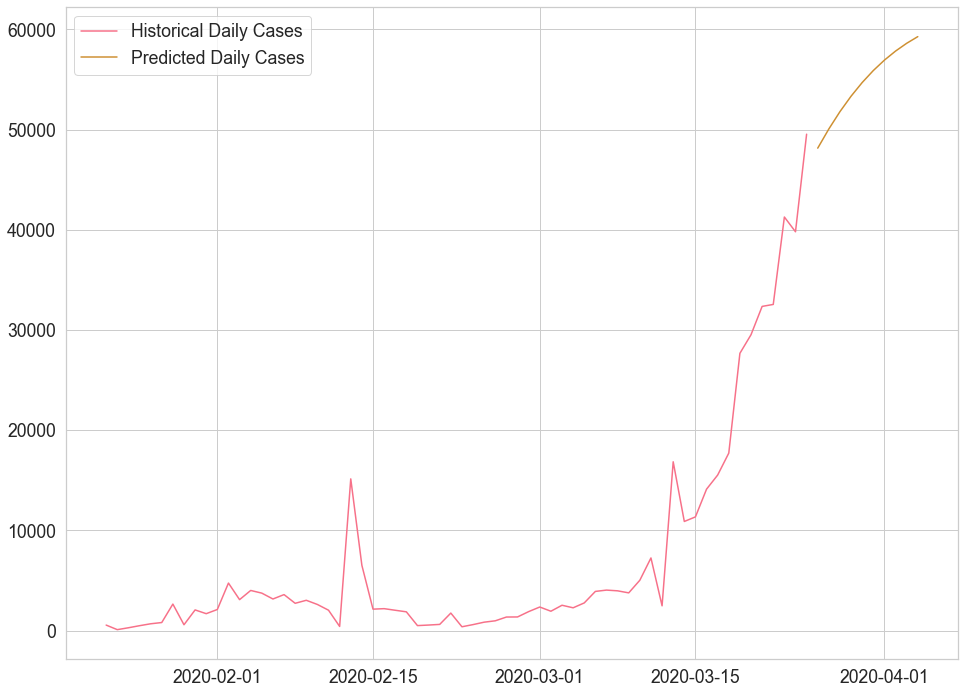

In [121]:
plt.plot(world_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

Lets collect data for prediction for all of the countries in our data set.

## US States Analysis

### CA

To do our analyses on US States, we can just feed in an abbreviation, but we have a good amount of disparatae naming that takes place in our data set that looks like so.

In [80]:
states_df = pd.read_csv('./data/jhu_data/time_series_19-covid-Confirmed_3_22.csv')
states_df.drop(columns=['Unnamed: 0'],inplace=True)

In [81]:
# some state names
states_df[states_df['Country/Region']=='US'][:5]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,568,572,643,904,1076,1014,1376,1524,1793,1996
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,421,525,732,967,1706,2495,5365,8310,11710,15793
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,282,340,426,557,698,751,952,1177,1364,1642
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,123,138,164,197,218,218,328,413,525,646
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,46,47,47,47,47,49,49,49


In [82]:
# some mixed types
states_df[states_df['Country/Region']=='US'][-5:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,0,3,5,5,5,5,5,14,21,23
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,0,3,3,3,5,12,14,15,27
448,Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,1,1,1,2,2,3,3,3,3
491,United States Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492,US,US,37.0902,-95.7129,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So lets get some of this from a hand json we were already using for geospatial information in our visualization to get some name metadata.

In [83]:
with open('./data/geo_data/us-states.json', 'r') as f:
    us_states = json.load(f)
    
state_abrs = [x['id'] for x in us_states['features']]

state_mapper_lst = [{x['properties']['name']:x['id']} for x in us_states['features']]

state_mapper_lst
state_mapper = {}
for s in state_mapper_lst:
    state_mapper.update(s)

First, lets pick a state that has a considerable outbreak, California.

In [92]:
wa_data_loader = LSTM_data_loader(df=states_df,
                          region_abr='WA',
                          country='US',
                          region_list=None,
                          state_mapper=state_mapper)

In [93]:
wa_data_loader.subset_df()
wa_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [94]:
wa_data_loader.transform_df_datetime()
wa_data_loader.df.head()

Data in cumulative


2020-01-22    1
2020-01-23    1
2020-01-24    1
2020-01-25    1
2020-01-26    1
dtype: int64

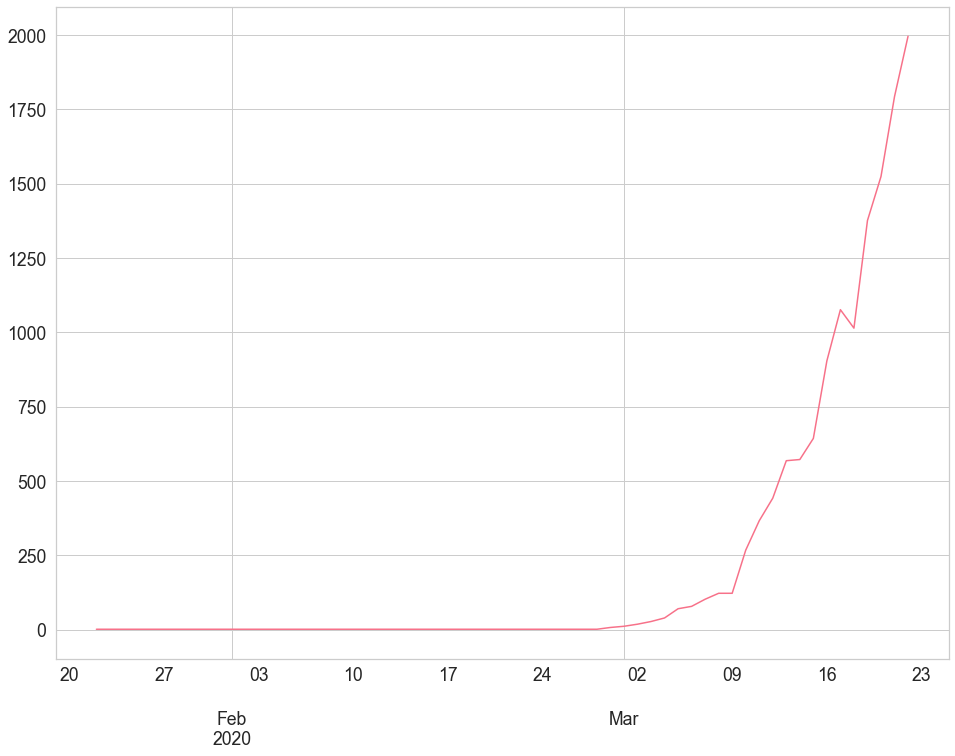

In [95]:
wa_data_loader.df.plot(label="Confirmed Cases")

In [112]:
wa_data_loader.gen_data_sets(test_data_size=9)

In [113]:
wa_data_loader.test_data

array([[1.00705467],
       [1.13227513],
       [1.59259259],
       [1.89594356],
       [1.78659612],
       [2.42504409],
       [2.68606702],
       [3.16049383],
       [3.51851852]])

In [114]:
X_train, y_train = ca_data_loader.set_seq(train=True, sequence_lenth=3)
X_test, y_test = ca_data_loader.set_seq(train=False, sequence_lenth=3)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [115]:
len(X_train)

52

In [66]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [67]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=300)

Epoch 0 train loss: 2.236250877380371 test loss: 4.03095006942749
Epoch 40 train loss: 1.0426058769226074 test loss: 3.0140223503112793
Epoch 80 train loss: 0.3049560487270355 test loss: 1.301385521888733
Epoch 120 train loss: 0.2944057583808899 test loss: 1.4257220029830933
Epoch 160 train loss: 0.27429354190826416 test loss: 1.3283854722976685
Epoch 200 train loss: 0.28727132081985474 test loss: 1.3310052156448364
Epoch 240 train loss: 0.28152066469192505 test loss: 1.3347845077514648
Epoch 280 train loss: 0.2957763373851776 test loss: 1.373891830444336


In [69]:
X_test

tensor([[[1.0759],
         [1.3639],
         [1.6862]]])

In [68]:
seq_length = model.sequences

with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = wa_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = wa_data_loader.scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
print(predicted_cases)

[1116.8224]
[664.42988169]


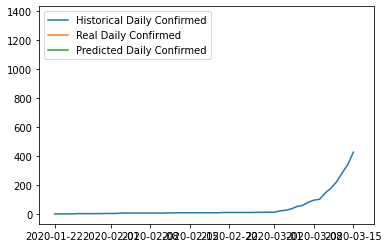

In [27]:
plt.plot(
  ca_data_loader.df.index[:len(ca_data_loader.train_data)],
  ca_data_loader.scaler.inverse_transform(ca_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  ca_data_loader.df.index[len(ca_data_loader.train_data):len(ca_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  ca_data_loader.df.index[len(ca_data_loader.train_data):len(ca_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

### CO

Lets try a state with some cases, but considerable less data, Colorado.

In [15]:
co_data_loader = LSTM_data_loader(df=tdf,
                          region_abr='CO',
                          country='US',
                          region_list=state_abrs,
                          state_mapper=state_mapper)

In [16]:
co_data_loader.subset_df()
co_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,0,0,0,0,0,0,0,0,0,0,...,7,7,15,34,45,49,101,131,160,160


In [17]:
co_data_loader.transform_df_datetime()
co_data_loader.df.head()

2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

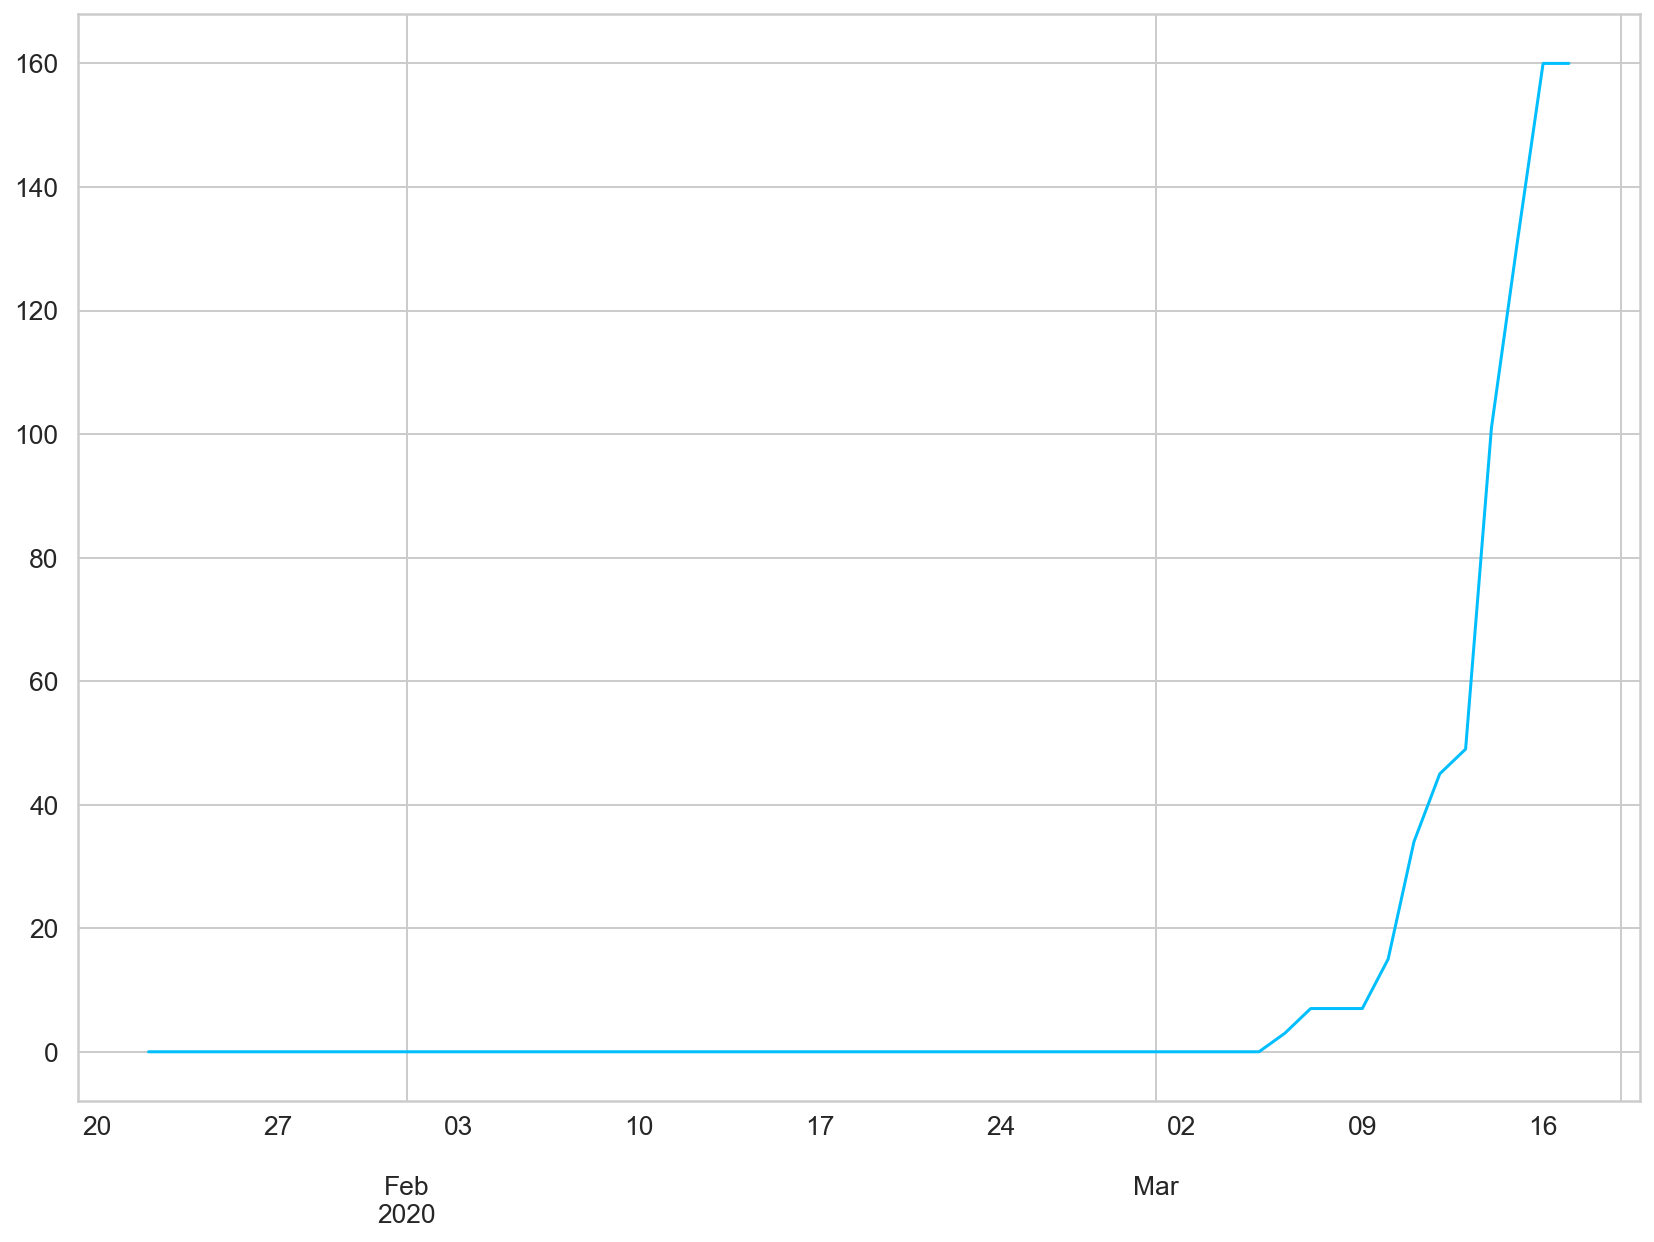

In [18]:
co_data_loader.df.plot(label="Confirmed Cases")

In [19]:
co_data_loader.gen_data_sets(test_data_size=0)

In [20]:
X_train, y_train = co_data_loader.set_seq()
# X_test, y_test = co_data_loader.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
# X_test = torch.from_numpy(X_test).float()
# y_test = torch.from_numpy(y_test).float()

In [21]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [22]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=300)

Epoch 0 train loss: 2.1966371536254883
Epoch 20 train loss: 2.0544867515563965
Epoch 40 train loss: 2.043541431427002
Epoch 60 train loss: 2.028346538543701
Epoch 80 train loss: 2.0070838928222656
Epoch 100 train loss: 1.9903323650360107
Epoch 120 train loss: 1.9673469066619873
Epoch 140 train loss: 1.926859974861145
Epoch 160 train loss: 1.8918440341949463
Epoch 180 train loss: 1.8268221616744995
Epoch 200 train loss: 1.730825662612915
Epoch 220 train loss: 1.580679178237915
Epoch 240 train loss: 1.3450826406478882
Epoch 260 train loss: 1.008018136024475
Epoch 280 train loss: 0.6542141437530518


In [131]:
seq_length = model.sequences

with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = co_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = co_data_loader.scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
print(predicted_cases)

[101. 131. 160.]
[55.27002096 56.60356522 56.55660868]


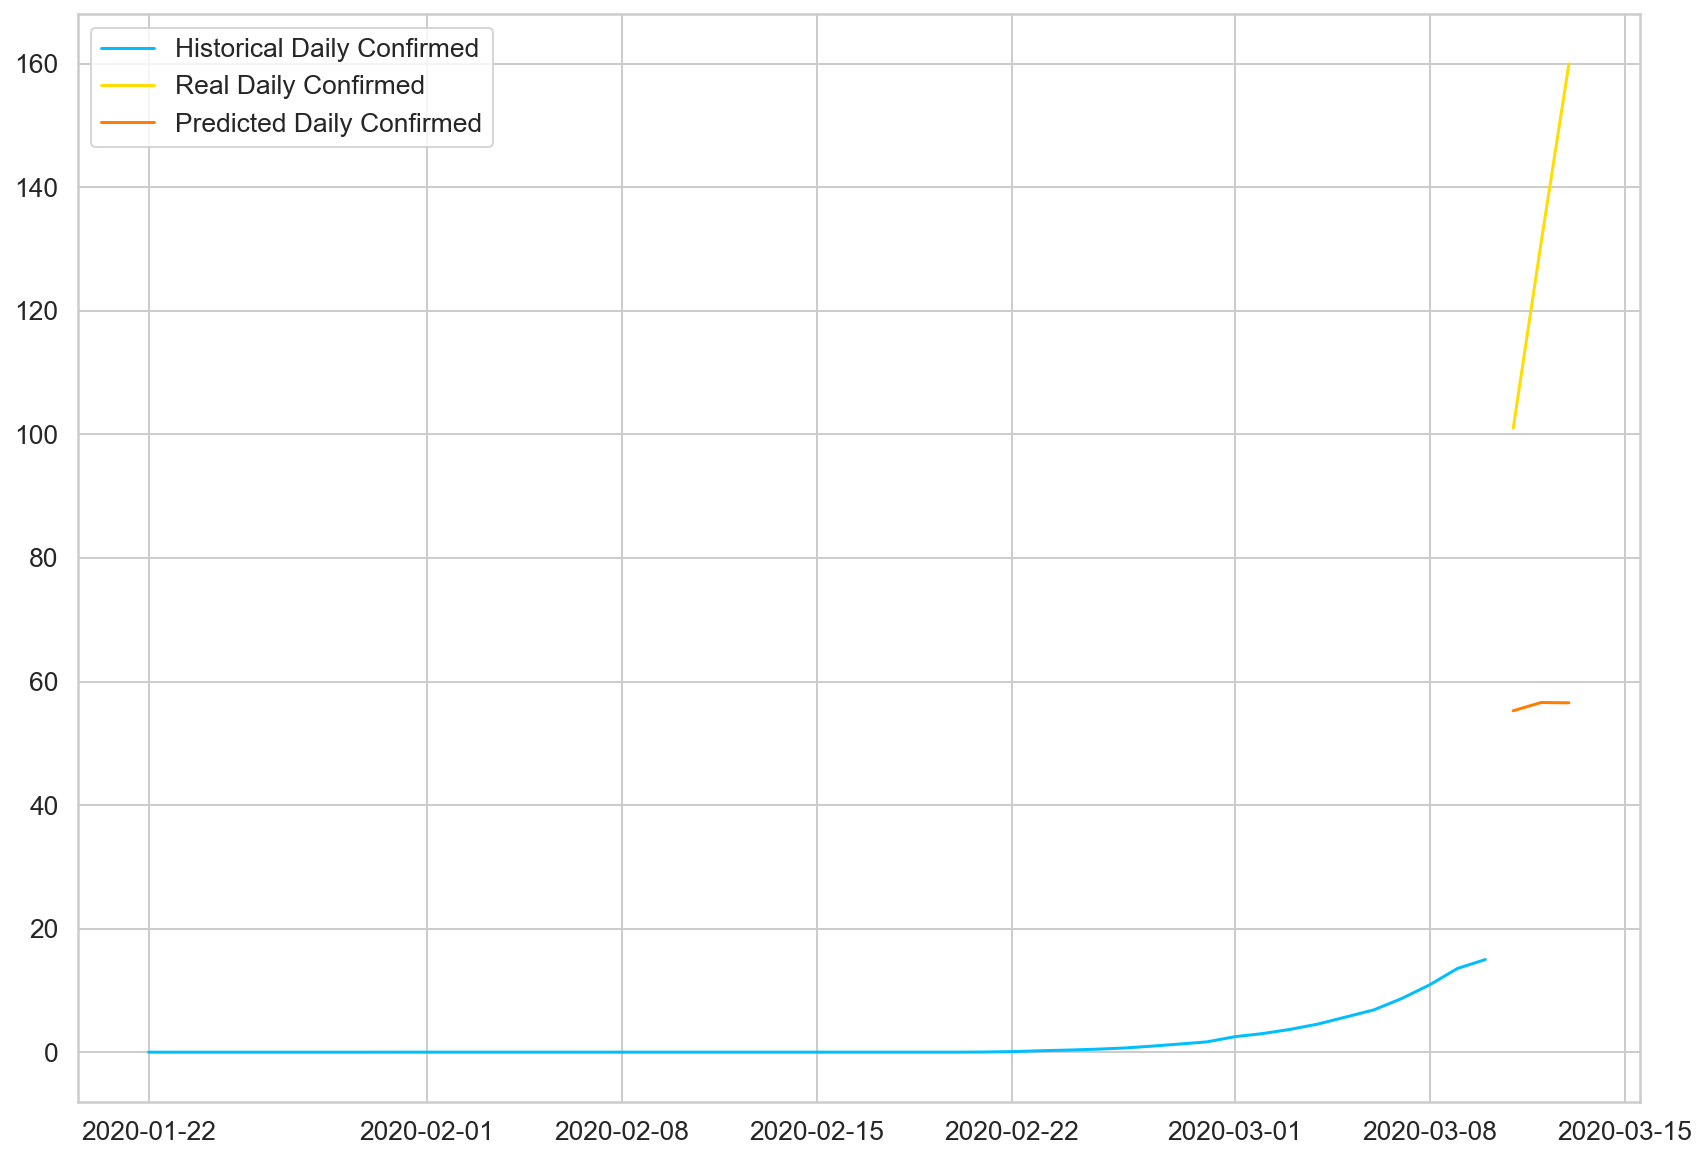

In [132]:
plt.plot(
  co_data_loader.df.index[:len(italy_data_loader.train_data)],
  co_data_loader.scaler.inverse_transform(italy_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  co_data_loader.df.index[len(co_data_loader.train_data):len(co_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  co_data_loader.df.index[len(co_data_loader.train_data):len(co_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

In [63]:
test_dl.df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,50,53,59,70,75,82,114,147,177
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,502,511,581,639,639,701,773,839,825,878
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,150,160,178,178,200,212,226,243,266
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,99,117,129,149,149,197,238,428,566,673


In [64]:
test_dl.subset_df()
test_dl.transform_df_datetime()
test_dl.gen_data_sets(test_data_size=5)

X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

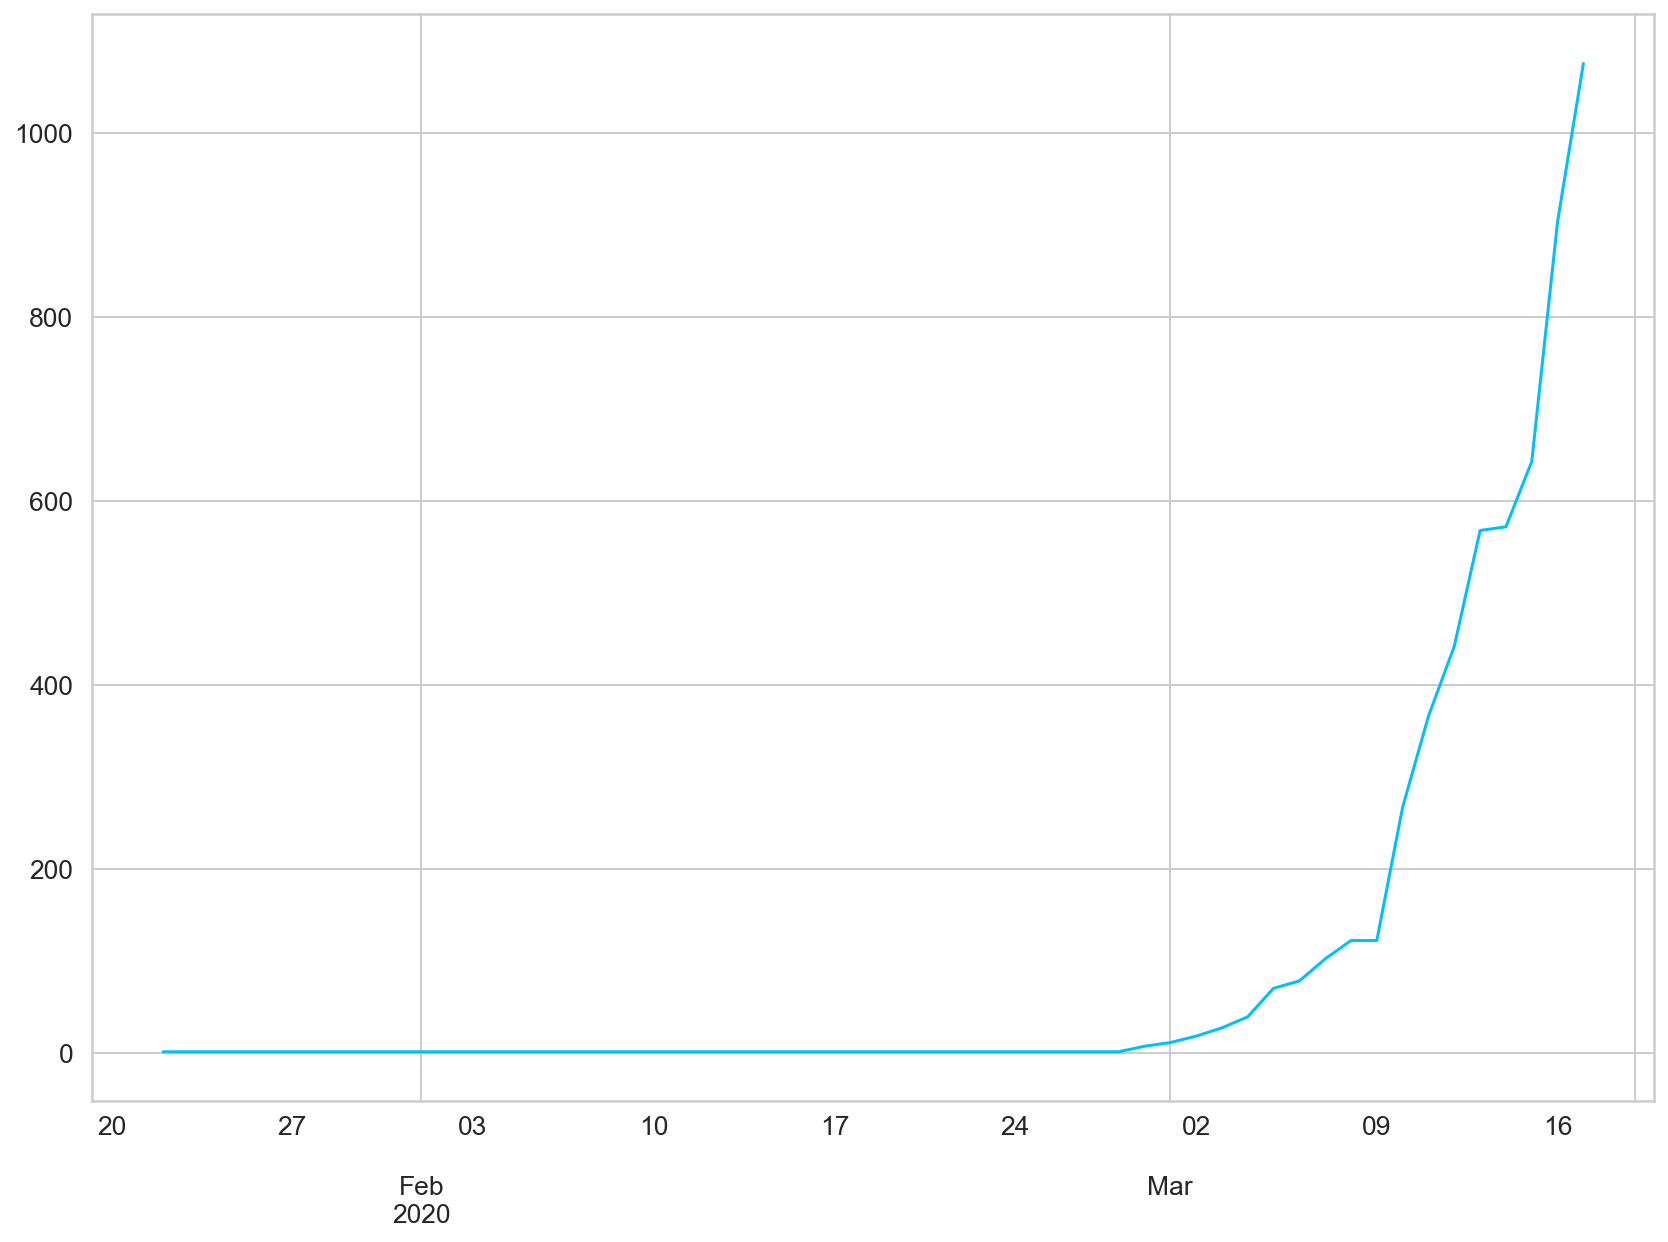

In [65]:
test_dl.df.plot()

In [18]:
test_dl.gen_data_sets(test_data_size=5)

In [22]:
test_dl.test_data.shape

(5, 1)

In [28]:
X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

In [29]:
X_test, y_test = test_dl.set_seq(train=False)

In [30]:
X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [31]:
y_test.shape

torch.Size([1, 1])

In [66]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.3
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [67]:
def train_model(model, train_data, train_labels, test_data=None,test_labels=None, n_epochs=300):
    
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

  train_hist = np.zeros(n_epochs)
  test_hist = np.zeros(n_epochs)

  for t in range(n_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [68]:
test_dl.sequence_lenth

3

In [ ]:
data_saver = {}

for s in state_abrs:
    print(s)
    
    # Instanial our loader / transformer
    test_dl = LSTM_data_loader(df=tdf,
                          region_abr=s,
                          country='US',
                          region_list=state_abrs,
                          state_mapper=state_mapper,
                          sequence_lenth=2)
    
    test_dl.subset_df()
    test_dl.transform_df_datetime()
    test_dl.gen_data_sets(test_data_size=5)

    X_train, y_train = test_dl.set_seq()
    X_test, y_test = test_dl.set_seq(train=False)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    
    model = CoronaVirusPredictor(
      n_features=1,
      n_hidden=512,
      seq_len=test_dl.sequence_lenth,
      n_layers=2
    )
    
    model, train_hist, test_hist = train_model(
      model,
      X_train,
      y_train,
      X_test,
      y_test
    )
    
    with torch.no_grad():
        test_seq = X_test[:1]
        preds = []
        for _ in range(len(X_test)):
            y_test_pred = model(test_seq)
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(1, test_dl.sequence_lenth, 1).float()
        
    true_cases = test_dl.scaler.inverse_transform(
        np.expand_dims(y_test.flatten().numpy(), axis=0)
    ).flatten()

    predicted_cases = test_dl.scaler.inverse_transform(
      np.expand_dims(preds, axis=0)
    ).flatten()
    
    data_saver[s] = {
        'train_hist' : train_hist,
        'test_hist' : test_hist,
        'xtrain' : X_train,
        'xtest' : X_test,
        'ytrain' : y_test,
        'ytest' : y_test,
        'true_cases' : true_cases,
        'predicted_cases' : predicted_cases
    }
    
#     print(data_saver)
    

AL
Epoch 0 train loss: 0.015116780996322632 test loss: 840.7821044921875
Epoch 10 train loss: 0.000842939771246165 test loss: 841.9154663085938
Epoch 20 train loss: 0.00034307068563066423 test loss: 841.4600219726562
Epoch 30 train loss: 6.466620834544301e-05 test loss: 841.6046752929688
Epoch 40 train loss: 4.568230360746384e-05 test loss: 841.0740356445312
Epoch 50 train loss: 5.4447704314952716e-05 test loss: 841.3905639648438
Epoch 60 train loss: 3.3299300412181765e-05 test loss: 841.512939453125
Epoch 70 train loss: 2.7880714696948417e-05 test loss: 841.5054321289062
Epoch 80 train loss: 1.38671493914444e-05 test loss: 841.2974853515625
Epoch 90 train loss: 2.727984610828571e-05 test loss: 841.1526489257812
Epoch 100 train loss: 1.6872987544047646e-05 test loss: 841.3693237304688
Epoch 110 train loss: 1.7924165149452165e-05 test loss: 841.260986328125
Epoch 120 train loss: 9.405270247953013e-06 test loss: 841.2653198242188
Epoch 130 train loss: 1.1219893167435657e-05 test loss: 84

Epoch 240 train loss: 0.02716771699488163 test loss: 13.419187545776367
Epoch 250 train loss: 0.02716328576207161 test loss: 13.418224334716797
Epoch 260 train loss: 0.027191972360014915 test loss: 13.418869018554688
Epoch 270 train loss: 0.027178103104233742 test loss: 13.418645858764648
Epoch 280 train loss: 0.027196185663342476 test loss: 13.419631004333496
Epoch 290 train loss: 0.027194391936063766 test loss: 13.419716835021973
CA
Epoch 0 train loss: 1.5589170455932617 test loss: 6.199007987976074
Epoch 10 train loss: 1.336113691329956 test loss: 5.893967151641846
Epoch 20 train loss: 1.3174742460250854 test loss: 5.796813011169434
Epoch 30 train loss: 1.3210148811340332 test loss: 5.830250263214111
Epoch 40 train loss: 1.3108105659484863 test loss: 5.846858978271484
Epoch 50 train loss: 1.3056042194366455 test loss: 5.788836479187012
Epoch 60 train loss: 1.2994680404663086 test loss: 5.788129806518555
Epoch 70 train loss: 1.2997872829437256 test loss: 5.785080909729004
Epoch 80 tr

Epoch 210 train loss: 0.9788953065872192 test loss: 63.66207504272461
Epoch 220 train loss: 0.9792458415031433 test loss: 63.6580810546875
Epoch 230 train loss: 0.9785518646240234 test loss: 63.65434646606445
Epoch 240 train loss: 0.9784905910491943 test loss: 63.65913772583008
Epoch 250 train loss: 0.9786286950111389 test loss: 63.66182327270508
Epoch 260 train loss: 0.9789419770240784 test loss: 63.670166015625
Epoch 270 train loss: 0.9783501029014587 test loss: 63.65839385986328
Epoch 280 train loss: 0.9782195091247559 test loss: 63.66166687011719
Epoch 290 train loss: 0.9786189794540405 test loss: 63.65826416015625
FL
Epoch 0 train loss: 1.0808014869689941 test loss: 19.559371948242188
Epoch 10 train loss: 0.9819851517677307 test loss: 19.15243911743164
Epoch 20 train loss: 0.9718008041381836 test loss: 19.061920166015625
Epoch 30 train loss: 0.9792823791503906 test loss: 19.129440307617188
Epoch 40 train loss: 0.9691051840782166 test loss: 19.09193229675293
Epoch 50 train loss: 0.

Epoch 180 train loss: 5.682180926669389e-06 test loss: 24.99638557434082
Epoch 190 train loss: 1.0674978511815425e-05 test loss: 25.000991821289062
Epoch 200 train loss: 6.933822533028433e-06 test loss: 25.00417709350586
Epoch 210 train loss: 6.656477125943638e-06 test loss: 25.00012969970703
Epoch 220 train loss: 6.5797908064268995e-06 test loss: 24.996601104736328
Epoch 230 train loss: 5.295514711178839e-06 test loss: 24.994722366333008
Epoch 240 train loss: 6.076490080886288e-06 test loss: 24.994802474975586
Epoch 250 train loss: 6.529847269121092e-06 test loss: 24.998126983642578
Epoch 260 train loss: 5.505810804606881e-06 test loss: 24.994802474975586
Epoch 270 train loss: 8.209446605178528e-06 test loss: 24.9930477142334
Epoch 280 train loss: 7.410252237605164e-06 test loss: 24.993419647216797
Epoch 290 train loss: 7.573821221740218e-06 test loss: 24.99251937866211
IL
Epoch 0 train loss: 0.7534053325653076 test loss: 10.408665657043457
Epoch 10 train loss: 0.6531982421875 test lo

Epoch 150 train loss: 2.748412847518921 test loss: 105.03233337402344
Epoch 160 train loss: 2.6001014709472656 test loss: 102.43873596191406
Epoch 170 train loss: 2.400012493133545 test loss: 99.32608795166016
Epoch 180 train loss: 2.1820831298828125 test loss: 96.0388412475586
Epoch 190 train loss: 1.9551095962524414 test loss: 90.55964660644531
Epoch 200 train loss: 1.7294142246246338 test loss: 87.01893615722656
Epoch 210 train loss: 1.513485312461853 test loss: 80.54681396484375
Epoch 220 train loss: 1.3868120908737183 test loss: 77.11263275146484
Epoch 230 train loss: 1.1907981634140015 test loss: 73.17290496826172
Epoch 240 train loss: 1.1440991163253784 test loss: 70.36378479003906
Epoch 250 train loss: 1.0348793268203735 test loss: 71.68871307373047
Epoch 260 train loss: 1.0059469938278198 test loss: 65.79500579833984
Epoch 270 train loss: 0.9297121167182922 test loss: 67.73819732666016
Epoch 280 train loss: 0.9782529473304749 test loss: 68.1329345703125
Epoch 290 train loss: 0

Epoch 110 train loss: 1.269925832748413 test loss: 11.059244155883789
Epoch 120 train loss: 1.2624435424804688 test loss: 11.0684175491333
Epoch 130 train loss: 1.2606041431427002 test loss: 11.042865753173828
Epoch 140 train loss: 1.2602542638778687 test loss: 11.017129898071289
Epoch 150 train loss: 1.2493548393249512 test loss: 10.983449935913086
Epoch 160 train loss: 1.2423734664916992 test loss: 10.943428039550781
Epoch 170 train loss: 1.23664391040802 test loss: 10.911760330200195
Epoch 180 train loss: 1.227285623550415 test loss: 10.864859580993652
Epoch 190 train loss: 1.2227773666381836 test loss: 10.798946380615234
Epoch 200 train loss: 1.211890459060669 test loss: 10.845260620117188
Epoch 210 train loss: 1.2018940448760986 test loss: 10.743834495544434
Epoch 220 train loss: 1.1991299390792847 test loss: 10.690139770507812
Epoch 230 train loss: 1.1817700862884521 test loss: 10.644877433776855
Epoch 240 train loss: 1.1655360460281372 test loss: 10.535587310791016
Epoch 250 tra

In [49]:
save_the_data_317 = data_saver

In [35]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=test_dl.sequence_lenth,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 13.389084815979004 test loss: 1.9732123613357544
Epoch 10 train loss: 8.327491760253906 test loss: 1.5774154663085938
Epoch 20 train loss: 4.138882160186768 test loss: 1.0888692140579224
Epoch 30 train loss: 3.923527240753174 test loss: 0.6946665644645691
Epoch 40 train loss: 3.512434959411621 test loss: 0.8968299627304077
Epoch 50 train loss: 3.564000368118286 test loss: 0.9149094820022583
Epoch 60 train loss: 3.469043731689453 test loss: 0.8279104232788086
Epoch 70 train loss: 3.4717698097229004 test loss: 0.863163948059082
Epoch 80 train loss: 3.4912571907043457 test loss: 0.855752170085907
Epoch 90 train loss: 3.526294469833374 test loss: 0.8283991813659668
Epoch 100 train loss: 3.4745535850524902 test loss: 0.8497444987297058
Epoch 110 train loss: 3.442981481552124 test loss: 0.8435304760932922
Epoch 120 train loss: 3.3929386138916016 test loss: 0.8195550441741943
Epoch 130 train loss: 3.3693761825561523 test loss: 0.8279690146446228
Epoch 140 train loss: 3.379

In [ ]:
seq_length 

with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 10))
plt.legend()

In [ ]:
mask1 = confirmed_melted['Date'].str.contains(first_day)
mask2 = confirmed_melted['Country/Region'].str.contains('US')
first_day_df_US = confirmed_melted[mask1 & mask2]
first_day_df_US.head()

first_day_df_US = first_day_df_US[['Province/State','Confirmed']]

for x in state_abrs:
    counter=0
    for r in first_day_df_US['Province/State']:
        if x in r:
            first_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            first_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        

first_day_df_US = first_day_df_US.groupby('Province/State').sum().reset_index()
first_day_df_US.head()

In [ ]:
mask = confirmed_melted['Country/Region'].str.contains('US')
first_day_df_US = confirmed_melted[mask1 & mask2]
first_day_df_US.head()

first_day_df_US = first_day_df_US[['Province/State','Confirmed']]

for x in state_abrs:
    counter=0
    for r in first_day_df_US['Province/State']:
        if x in r:
            first_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            first_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        

first_day_df_US = first_day_df_US.groupby('Province/State').sum().reset_index()
first_day_df_US.head()